# Milestone 1: Data Extraction
In this notebook, we extract and clean the relevant data from the cvs files we downloaded from EIA. Recall that

**Label:** Actual Energy Price for ILLINOIS.HUB

The feature set includes **hourly** data of:
1. Forecasted Load
2. Day Ahead Energy Price
3. Day of Week
4. Hour of Day
5. Month
6. Energy prices in surrounding states
7. Predicted weather



In [ ]:
# Mount the data folder
from google.colab import drive
drive.mount('/content/drive')
datadir = '/content/drive/MyDrive/miso_project/data_raw/'

# relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from datetime import timedelta


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Locational Marginal Prices

**Note:** Although system conditions at any node can affect LMPs elsewhere, the project specifies using prices from surrounding states.

 MISO has 8 hubs (Note that Illinois and the surrounding hubs are in bold):
1. **Arkansas**
2. **Illinois**
3. **Indiana**
4. Louisiana
5. **Michigan**
6. **Minnesota**
7. Mississippi
8. Texas

We are going to predict next hour (t+1) actual energy price for Illinois. Thus, we can use lagged actual energy price values. We will need both DA and RT prices for these hubs.

Below, we oberve that The Day-Ahead and the Real-time markets share the same file structure by checking the column names.

In [ ]:
# Load the csv file for one of the real time files
csv_name = 'miso_lmp_rt_hr_hubs_2021.csv'
df = pd.read_csv(datadir + csv_name,header=3)
# print the column names
print(*df.columns, sep="\n")

UTC Timestamp (Interval Ending)
Local Timestamp Eastern Standard Time (Interval Beginning)
Local Timestamp Eastern Standard Time (Interval Ending)
Local Date
Hour Number
Arkansas Hub LMP
Illinois Hub LMP
Indiana Hub LMP
Louisiana Hub LMP
Michigan Hub LMP
Minnesota Hub LMP
Mississippi Hub LMP
Texas Hub LMP
Arkansas Hub (Congestion)
Illinois Hub (Congestion)
Indiana Hub (Congestion)
Louisiana Hub (Congestion)
Michigan Hub (Congestion)
Minnesota Hub (Congestion)
Mississippi Hub (Congestion)
Texas Hub (Congestion)
Arkansas Hub (Loss)
Illinois Hub (Loss)
Indiana Hub (Loss)
Louisiana Hub (Loss)
Michigan Hub (Loss)
Minnesota Hub (Loss)
Mississippi Hub (Loss)
Texas Hub (Loss)


In [ ]:
# Load the csv file for one of the day ahead files
csv_name = 'miso_lmp_da_hr_hubs_2021.csv'
df = pd.read_csv(datadir + csv_name,header=3)
print(*df.columns, sep="\n")

UTC Timestamp (Interval Ending)
Local Timestamp Eastern Standard Time (Interval Beginning)
Local Timestamp Eastern Standard Time (Interval Ending)
Local Date
Hour Number
Arkansas Hub LMP
Illinois Hub LMP
Indiana Hub LMP
Louisiana Hub LMP
Michigan Hub LMP
Minnesota Hub LMP
Mississippi Hub LMP
Texas Hub LMP
Arkansas Hub (Congestion)
Illinois Hub (Congestion)
Indiana Hub (Congestion)
Louisiana Hub (Congestion)
Michigan Hub (Congestion)
Minnesota Hub (Congestion)
Mississippi Hub (Congestion)
Texas Hub (Congestion)
Arkansas Hub (Loss)
Illinois Hub (Loss)
Indiana Hub (Loss)
Louisiana Hub (Loss)
Michigan Hub (Loss)
Minnesota Hub (Loss)
Mississippi Hub (Loss)
Texas Hub (Loss)


In [ ]:
df.head(n=24)

,UTC Timestamp (Interval Ending),Local Timestamp Eastern Standard Time (Interval Beginning),Local Timestamp Eastern Standard Time (Interval Ending),Local Date,Hour Number,Arkansas Hub LMP,Illinois Hub LMP,Indiana Hub LMP,Louisiana Hub LMP,Michigan Hub LMP,...,Mississippi Hub (Congestion),Texas Hub (Congestion),Arkansas Hub (Loss),Illinois Hub (Loss),Indiana Hub (Loss),Louisiana Hub (Loss),Michigan Hub (Loss),Minnesota Hub (Loss),Mississippi Hub (Loss),Texas Hub (Loss)
0,2021-01-01 06:00:00,2021-01-01 00:00:00,2021-01-01 01:00:00,2021-01-01,1,18.95,18.82,19.56,19.56,19.90,...,0.0,-0.28,-0.24,-0.37,0.37,0.37,0.71,-1.11,0.27,0.33
1,2021-01-01 07:00:00,2021-01-01 01:00:00,2021-01-01 02:00:00,2021-01-01,2,18.17,18.90,19.67,18.42,19.74,...,0.0,0.00,-0.61,0.12,0.89,-0.36,0.96,-1.00,-0.26,-0.33
2,2021-01-01 08:00:00,2021-01-01 02:00:00,2021-01-01 03:00:00,2021-01-01,3,17.84,18.73,19.34,18.27,19.37,...,0.0,-0.03,-0.66,0.23,0.84,-0.23,0.87,-1.05,0.03,-0.40
3,2021-01-01 09:00:00,2021-01-01 03:00:00,2021-01-01 04:00:00,2021-01-01,4,18.12,19.02,19.63,18.56,19.69,...,0.0,0.00,-0.61,0.29,0.90,-0.17,0.96,-1.34,0.06,-0.24
4,2021-01-01 10:00:00,2021-01-01 04:00:00,2021-01-01 05:00:00,2021-01-01,5,17.97,19.11,19.72,18.44,19.78,...,-0.2,-0.23,-0.61,0.29,0.90,-0.17,0.96,-1.34,0.06,-0.24
5,2021-01-01 11:00:00,2021-01-01 05:00:00,2021-01-01 06:00:00,2021-01-01,6,18.41,18.38,18.38,18.50,18.32,...,0.0,0.00,-0.36,-0.39,-0.39,-0.27,-0.45,0.63,-0.31,-0.61
6,2021-01-01 12:00:00,2021-01-01 06:00:00,2021-01-01 07:00:00,2021-01-01,7,19.74,20.36,21.07,20.43,21.34,...,0.0,0.00,-0.45,0.17,0.88,0.24,1.15,-2.27,0.34,-0.11
7,2021-01-01 13:00:00,2021-01-01 07:00:00,2021-01-01 08:00:00,2021-01-01,8,20.20,20.84,21.56,20.90,21.83,...,0.0,0.00,-0.47,0.17,0.89,0.23,1.16,-2.33,0.34,-0.12
8,2021-01-01 14:00:00,2021-01-01 08:00:00,2021-01-01 09:00:00,2021-01-01,9,21.18,20.83,21.69,21.15,21.52,...,0.0,0.00,-0.10,-0.54,0.41,-0.13,0.23,-0.97,-0.07,0.17
9,2021-01-01 15:00:00,2021-01-01 09:00:00,2021-01-01 10:00:00,2021-01-01,10,21.44,21.68,21.70,21.81,21.81,...,0.0,0.00,-0.53,-0.38,-0.27,-0.16,-0.17,0.34,-0.15,-1.22


Now, let's combine data from 2021 to 2024.

In [ ]:
def concatanate_LMP_data(csv_list, selected_columns, price_type):
  # create empty df
  column_names = ["UTC Timestamp (Interval Ending)"] + selected_columns
  df = pd.DataFrame(columns=column_names)

  # add dfs
  for csv_name in csv_list:
    df_temp = pd.read_csv(datadir + csv_name, header=3)
    df_temp = df_temp[column_names]
    df_temp["UTC Timestamp (Interval Ending)"] = pd.to_datetime(df_temp["UTC Timestamp (Interval Ending)"], format="%Y-%m-%d %H:%M:%S", errors="coerce") # With errors="coerce": bad/unparseable timestamps become NaT
    df = pd.concat([df, df_temp], ignore_index=True)

  # Add price type info to the column name (we basically change the column name)
  if str(price_type).upper() == "DA":
    df.rename(
        columns={c: c.replace("Hub LMP", "DALMP") for c in selected_columns},
        inplace=True)
  elif str(price_type).upper() == "RT":
    df.rename(
        columns={c: c.replace("Hub LMP", "RTLMP") for c in selected_columns},
        inplace=True)
  df.rename(columns={"UTC Timestamp (Interval Ending)": "Timestamp"}, inplace=True)

  return df

csv_list = ['miso_lmp_da_hr_hubs_2021.csv','miso_lmp_da_hr_hubs_2022.csv','miso_lmp_da_hr_hubs_2023.csv','miso_lmp_da_hr_hubs_2024.csv']
selected_columns = ['Arkansas Hub LMP', 'Illinois Hub LMP', 'Indiana Hub LMP', 'Michigan Hub LMP', 'Minnesota Hub LMP']
df_lmp_da = concatanate_LMP_data(csv_list, selected_columns, price_type = 'DA')
df_lmp_da.head()

/tmp/ipython-input-2452262955.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)


,Timestamp,Arkansas DALMP,Illinois DALMP,Indiana DALMP,Michigan DALMP,Minnesota DALMP
0,2021-01-01 06:00:00,18.95,18.82,19.56,19.90,16.92
1,2021-01-01 07:00:00,18.17,18.90,19.67,19.74,16.92
2,2021-01-01 08:00:00,17.84,18.73,19.34,19.37,16.80
3,2021-01-01 09:00:00,18.12,19.02,19.63,19.69,17.39
4,2021-01-01 10:00:00,17.97,19.11,19.72,19.78,17.74


In [ ]:
# RT prices
csv_list = ['miso_lmp_rt_hr_hubs_2021.csv','miso_lmp_rt_hr_hubs_2022.csv','miso_lmp_rt_hr_hubs_2023.csv','miso_lmp_rt_hr_hubs_2024.csv']
selected_columns = ['Arkansas Hub LMP', 'Illinois Hub LMP', 'Indiana Hub LMP', 'Michigan Hub LMP', 'Minnesota Hub LMP']
df_lmp_rt = concatanate_LMP_data(csv_list, selected_columns, price_type = 'RT')

/tmp/ipython-input-2452262955.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)


# Forecasted and Actual Load Data
Again, we are going to predict next hour (t+1) actual energy price for Illinois. Thus, we can use lagged actual load values.

MISO has 10 LRZs that are grouped as follows:
1. LRZ 1 (States: MT, ND, SD, MN, WI, IL)
2. LRZ 2, 7 (States: WI, MI)
3. LRZ 3, 5 (States: MN, IA, KS, IL)
4. LRZ 4 (States: IL)
5. LRZ 6 (States: IN)
6. LRZ 8, 9, 10 (States: MO, TX, MS, AL)

Below, we see that columns 7-12 are the actual loads and columns 13-18 are the forecasted loads.

In [ ]:
df = pd.read_csv(datadir + "miso_load-temp_hr_2021.csv",header=3)
col_names = df.columns.tolist()
for i, col in enumerate(df.columns):
    print(i, col)

0 UTC Timestamp (Interval Ending)
1 Local Timestamp Eastern Standard Time (Interval Beginning)
2 Local Timestamp Eastern Standard Time (Interval Ending)
3 Local Date
4 Hour Number
5 MISO Total Actual Load (MW)
6 MISO Total Forecast Load (MW)
7 LRZ 1 (States: MT, ND, SD, MN, WI, IL)
Balancing Authorities: DPC, GRE, MDU, MP, NSP, OTP, SMP Actual Load (MW)
8 LRZ 2, 7 (States: WI, MI)
Balancing Authorities: ALTE, MGE, UPPC, WEC, WPS, MIUP, CONS, DECO Actual Load (MW)
9 LRZ 3, 5 (States: MN, IA, KS, IL)
Balancing Authorities: ALTW, MEC, MPW, AMMO, CWLD Actual Load (MW)
10 LRZ 4 (States: IL)
Balancing Authorities: AMIL, CWLP, SIPC Actual Load (MW)
11 LRZ 6 (States: IN)
Balancing Authorities: BREC, CIN, HE, IPL, NIPSCO, SIGE Actual Load (MW)
12 LRZ 8, 9, 10 (States: MO, TX, MS, AL)
Balancing Authorities: EAI, CLEC, EES, LAFA, LAGN, LEPA, EMBA, SME Actual Load (MW)
13 LRZ 1 (States: MT, ND, SD, MN, WI, IL)
Balancing Authorities: DPC, GRE, MDU, MP, NSP, OTP, SMP Forecast Load (MW)
14 LRZ 2, 7 (

Combine the data into a single dataframe.

In [ ]:
selected_columns = col_names[13:19]

def concatanate_load_data(csv_list, selected_columns, load_type):
  # create empty df
  if str(load_type) == "actual":
    column_names = ["UTC Timestamp (Interval Ending)", "MISO Total Actual Load (MW)"] + selected_columns
    df = pd.DataFrame(columns=column_names)
  elif str(load_type) == "forecast":
    column_names = ["UTC Timestamp (Interval Ending)", "MISO Total Forecast Load (MW)"] + selected_columns
    df = pd.DataFrame(columns=column_names)

  # add dfs
  for csv_name in csv_list:
    df_temp = pd.read_csv(datadir + csv_name, header=3)
    df_temp = df_temp[column_names]
    df_temp["UTC Timestamp (Interval Ending)"] = pd.to_datetime(df_temp["UTC Timestamp (Interval Ending)"], format="%Y-%m-%d %H:%M:%S", errors="coerce") # With errors="coerce": bad/unparseable timestamps become NaT
    df = pd.concat([df, df_temp], ignore_index=True)

  # change column names
  if str(load_type) == "actual":
    df.rename(columns={"MISO Total Actual Load (MW)": "Total Actual Load"}, inplace=True)
    rename_dict = {c: str(c).split("(", 1)[0].strip().replace(',','_') + "_actual" for c in selected_columns}
    df.rename(columns=rename_dict, inplace=True)
  elif str(load_type) == "forecast":
    df.rename(columns={"MISO Total Forecast Load (MW)": "Total Forecast Load"}, inplace=True)
    rename_dict = {c: str(c).split("(", 1)[0].strip().replace(',','_') + "_forecast" for c in selected_columns}
    df.rename(columns=rename_dict, inplace=True)

  df.rename(columns={"UTC Timestamp (Interval Ending)": "Timestamp"}, inplace=True)

  return df

In [ ]:
# Forecasted load
csv_list = ['miso_load-temp_hr_2021.csv','miso_load-temp_hr_2022.csv','miso_load-temp_hr_2023.csv','miso_load-temp_hr_2024.csv']
selected_columns = col_names[13:19]
df_load_forecast = concatanate_load_data(csv_list, selected_columns, load_type = 'forecast')
# Actual load
selected_columns = col_names[7:13]
df_load_actual = concatanate_load_data(csv_list, selected_columns, load_type = 'actual')


/tmp/ipython-input-79523444.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)
/tmp/ipython-input-79523444.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)


In [ ]:
df_load_actual.head()

,Timestamp,Total Actual Load,LRZ 1_actual,LRZ 2_ 7_actual,LRZ 3_ 5_actual,LRZ 4_actual,LRZ 6_actual,LRZ 8_ 9_ 10_actual
0,2021-02-10 06:00:00,77859.97,12666.88,18226.97,11946.48,6142.86,11895.84,16980.94
1,2021-02-10 07:00:00,76211.10,12307.57,17785.44,11774.42,6016.02,11716.46,16611.19
2,2021-02-10 08:00:00,75295.06,12065.63,17582.40,11677.73,5940.12,11694.35,16334.83
3,2021-02-10 09:00:00,75164.21,12008.05,17527.62,11612.51,5994.92,11774.15,16246.96
4,2021-02-10 10:00:00,75743.83,11980.98,17753.76,11610.21,5995.74,12020.58,16382.56


# Temperature Data
MISO operates in 16 states (Alabama, Arkansas, Illinois, Indiana, Iowa, Kentucky, Louisiana, Michigan, Minnesota, Mississippi, Missouri, Montana, North Dakota, South Dakota, Texas, and Wisconsin). However, it only releases hourly temperature data for three different locations (Indianapolis, Minneapolis, and New Orleans). We include the forecasted temperatures for Indianapolis and Minneapolis as features due to these cities' proximity to Illinois. Since these datasets do not include hourly historical data for Illinois, we used another source from the Argonne National Laboratory.

Overall, we have the following locations for the temperature data:
1. Indianapolis
2. Minneapolis
3. Argonne National Lab

Let's start with Argonne:

In [ ]:
df=pd.read_csv(datadir + 'Air_temperature_argonne.txt', sep="\t", dtype={0: int, 1: str, 2: str, 3: str, 4:float, 5:int})
# Filter rows where Year is greater than 2021
df = df[df['Year'] >= 2021]
df.reset_index(drop=True, inplace=True)
df['hhmm'] = df['hhmm'].replace('2400', '0000')
df.head(n=27)

,Year,Month,Day,hhmm,Data,Flag
0,2021,01,01,100,21.92,0
1,2021,01,01,200,22.10,0
2,2021,01,01,300,22.28,0
3,2021,01,01,400,22.10,0
4,2021,01,01,500,23.90,0
5,2021,01,01,600,25.16,0
6,2021,01,01,700,26.60,0
7,2021,01,01,800,27.68,0
8,2021,01,01,900,28.76,0
9,2021,01,01,1000,29.84,0


We need to change the time to UTC.

In [ ]:
# Create a combined datetime column in CT
df['Timestamp_CT'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str) + ' ' +
                                     df['hhmm'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M', errors='coerce')

# Localize to Central Time and then convert to UTC
df['Timestamp'] = df['Timestamp_CT'].dt.tz_localize(
    'America/Chicago',
    nonexistent='shift_forward',
    ambiguous=False
).dt.tz_convert('UTC')

# Create the new DataFrame with UTC Timestamp and renamed temperature column
df_argonne_temp = df[['Timestamp', 'Data']].copy()
df_argonne_temp.rename(columns={'Data': 'Argonne_temp'}, inplace=True)
# Make  timestamp naive (drop tz info)
df_argonne_temp["Timestamp"] = df_argonne_temp["Timestamp"].dt.tz_localize(None)

df_argonne_temp.head(n=27)

,Timestamp,Argonne_temp
0,2021-01-01 07:00:00,21.92
1,2021-01-01 08:00:00,22.10
2,2021-01-01 09:00:00,22.28
3,2021-01-01 10:00:00,22.10
4,2021-01-01 11:00:00,23.90
5,2021-01-01 12:00:00,25.16
6,2021-01-01 13:00:00,26.60
7,2021-01-01 14:00:00,27.68
8,2021-01-01 15:00:00,28.76
9,2021-01-01 16:00:00,29.84


Observe the other cities. Timestamp is in ET. After converting these to UTC, we should round it to nearest datetime.

In [ ]:
df = pd.read_csv(datadir + "miso_load-temp_hr_2021.csv",header=3)
selected_columns = ["Indianapolis Temperature (Fahrenheit)", "Indianapolis Temperature Observation Time (Eastern Standard)",
             "Minneapolis Temperature (Fahrenheit)", "Minneapolis Temperature Observation Time (Eastern Standard)"]
df = df[selected_columns]
df.head()


,Indianapolis Temperature (Fahrenheit),Indianapolis Temperature Observation Time (Eastern Standard),Minneapolis Temperature (Fahrenheit),Minneapolis Temperature Observation Time (Eastern Standard)
0,19.9,2021-02-10 00:54:00,0.0,2021-02-10 00:53:00
1,19.9,2021-02-10 01:54:00,-0.9,2021-02-10 01:53:00
2,19.9,2021-02-10 02:54:00,-4.0,2021-02-10 02:53:00
3,19.9,2021-02-10 03:54:00,-2.0,2021-02-10 03:53:00
4,19.9,2021-02-10 04:54:00,-2.0,2021-02-10 04:53:00


In [ ]:
csv_list = ['miso_load-temp_hr_2021.csv','miso_load-temp_hr_2022.csv','miso_load-temp_hr_2023.csv','miso_load-temp_hr_2024.csv']

def concatanate_temp_data(csv_list, selected_columns):
  # empty dataframe
  df = pd.DataFrame(columns=selected_columns)

  for csv_name in csv_list:
    df_temp = pd.read_csv(datadir + csv_name, header=3)
    df_temp = df_temp[selected_columns]

    # Change ET to UTC
    df_temp[selected_columns[1]] = pd.to_datetime(df_temp[selected_columns[1]], format="%Y-%m-%d %H:%M:%S", errors="coerce")
    df_temp[selected_columns[1]] = df_temp[selected_columns[1]].dt.tz_localize(
    'America/New_York',
    nonexistent='shift_forward',
    ambiguous=False
    ).dt.tz_convert('UTC').dt.tz_localize(None)

    # Round time
    df_temp[selected_columns[1]] = df_temp[selected_columns[1]].dt.round('h')

    # Concatanate
    df = pd.concat([df, df_temp], ignore_index=True)
  return df

# Indiana
selected_columns = ["Indianapolis Temperature (Fahrenheit)", "Indianapolis Temperature Observation Time (Eastern Standard)"]
df_indianapolis_temp = concatanate_temp_data(csv_list, selected_columns)
df_indianapolis_temp = df_indianapolis_temp.set_axis(["Indianapolis_temp", "Timestamp"], axis=1)
df_indianapolis_temp.head(n=26)

/tmp/ipython-input-1956495288.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)


,Indianapolis_temp,Timestamp
0,19.9,2021-02-10 06:00:00
1,19.9,2021-02-10 07:00:00
2,19.9,2021-02-10 08:00:00
3,19.9,2021-02-10 09:00:00
4,19.9,2021-02-10 10:00:00
5,19.9,2021-02-10 11:00:00
6,19.9,2021-02-10 12:00:00
7,19.9,2021-02-10 13:00:00
8,19.9,2021-02-10 14:00:00
9,21.0,2021-02-10 15:00:00


In [ ]:
# Minneapolis
selected_columns = ["Minneapolis Temperature (Fahrenheit)", "Minneapolis Temperature Observation Time (Eastern Standard)"]
df_minneapolis_temp = concatanate_temp_data(csv_list, selected_columns)
df_minneapolis_temp = df_minneapolis_temp.set_axis(["Minneapolis_temp", "Timestamp"], axis=1)

/tmp/ipython-input-1956495288.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)


Now, we will put these cities together. We will only choose rows corresponting to common timestamps.

In [ ]:
# Merge df_argonne_temp with df_indianapolis_temp on common timestamps
df_temperature = pd.merge(df_argonne_temp, df_indianapolis_temp, on='Timestamp', how='inner')

# Merge the result with df_minneapolis_temp on common timestamps
df_temperature= pd.merge(df_temperature, df_minneapolis_temp, on='Timestamp', how='inner')

# # Drop rows where 'Timestamp' is NaT
df_temperature.dropna(subset=['Timestamp'], inplace=True, ignore_index=True)

# Ensure 'Timestamp' is the first column
columns = ['Timestamp'] + [col for col in df_temperature.columns if col != 'Timestamp']
df_temperature = df_temperature[columns]
df_temperature.head()

,Timestamp,Argonne_temp,Indianapolis_temp,Minneapolis_temp
0,2021-02-10 07:00:00,3.92,19.9,-0.9
1,2021-02-10 08:00:00,4.46,19.9,-4.0
2,2021-02-10 09:00:00,5.18,19.9,-2.0
3,2021-02-10 10:00:00,5.18,19.9,-2.0
4,2021-02-10 11:00:00,5.90,19.9,-0.9


# Missing Values
Check if there are any null values. Our end goal is to use an RNN model. For an RNN on time series, temporal order is very important.

First, we have some dataframes with different start and end dates. We will filter these out. We will only filter the data such that all data frames have the same starting and end datetime.

In [ ]:
# Min and max timestamps of each df
min_timestamps = [
    df_lmp_da['Timestamp'].min(),
    df_temperature['Timestamp'].min(),
    df_load_actual['Timestamp'].min(),
    df_lmp_rt['Timestamp'].min(),
    df_load_forecast['Timestamp'].min()
]
max_timestamps = [
    df_lmp_da['Timestamp'].max(),
    df_temperature['Timestamp'].max(),
    df_load_actual['Timestamp'].max(),
    df_lmp_rt['Timestamp'].max(),
    df_load_forecast['Timestamp'].max()
]

# The intersection min and max timestamps
min_timestamp = max(min_timestamps)
max_timestamp = min(max_timestamps)

print(f"Corrected Overall Minimum Timestamp: {min_timestamp}")
print(f"Corrected Overall Maximum Timestamp: {max_timestamp}")

df_lmp_da = df_lmp_da[(df_lmp_da['Timestamp'] >= min_timestamp) & (df_lmp_da['Timestamp'] <= max_timestamp)]
df_lmp_da.reset_index(drop=True, inplace=True)

df_temperature = df_temperature[(df_temperature['Timestamp'] >= min_timestamp) & (df_temperature['Timestamp'] <= max_timestamp)]
df_temperature.reset_index(drop=True, inplace=True)

df_load_actual = df_load_actual[(df_load_actual['Timestamp'] >= min_timestamp) & (df_load_actual['Timestamp'] <= max_timestamp)]
df_load_actual.reset_index(drop=True, inplace=True)

df_lmp_rt = df_lmp_rt[(df_lmp_rt['Timestamp'] >= min_timestamp) & (df_lmp_rt['Timestamp'] <= max_timestamp)]
df_lmp_rt.reset_index(drop=True, inplace=True)

df_load_forecast = df_load_forecast[(df_load_forecast['Timestamp'] >= min_timestamp) & (df_load_forecast['Timestamp'] <= max_timestamp)]
df_load_forecast.reset_index(drop=True, inplace=True)




Corrected Overall Minimum Timestamp: 2021-02-10 06:00:00
Corrected Overall Maximum Timestamp: 2023-10-01 04:00:00


Again, for an RNN on time series, temporal order is very important. We need to check which times have missing data between `min_timestamp` and `max_timestamp` for all dataframes we have created.

Below, we observe that until 7/23/2023, we only have a few data samples are missing. But, after this data, almost an entire month is missing (which I verified by checking the raw data). So, we will update `max_timestamp` and `min_timestamp` as `2023-07-23 00:00:00` and `2021-02-11 06:00:00`, respectively. Then, repeat the same procedure above.

/tmp/ipython-input-279563452.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_series = pd.Series(pd.date_range(start=min_timestamp, end=max_timestamp, freq='H'))


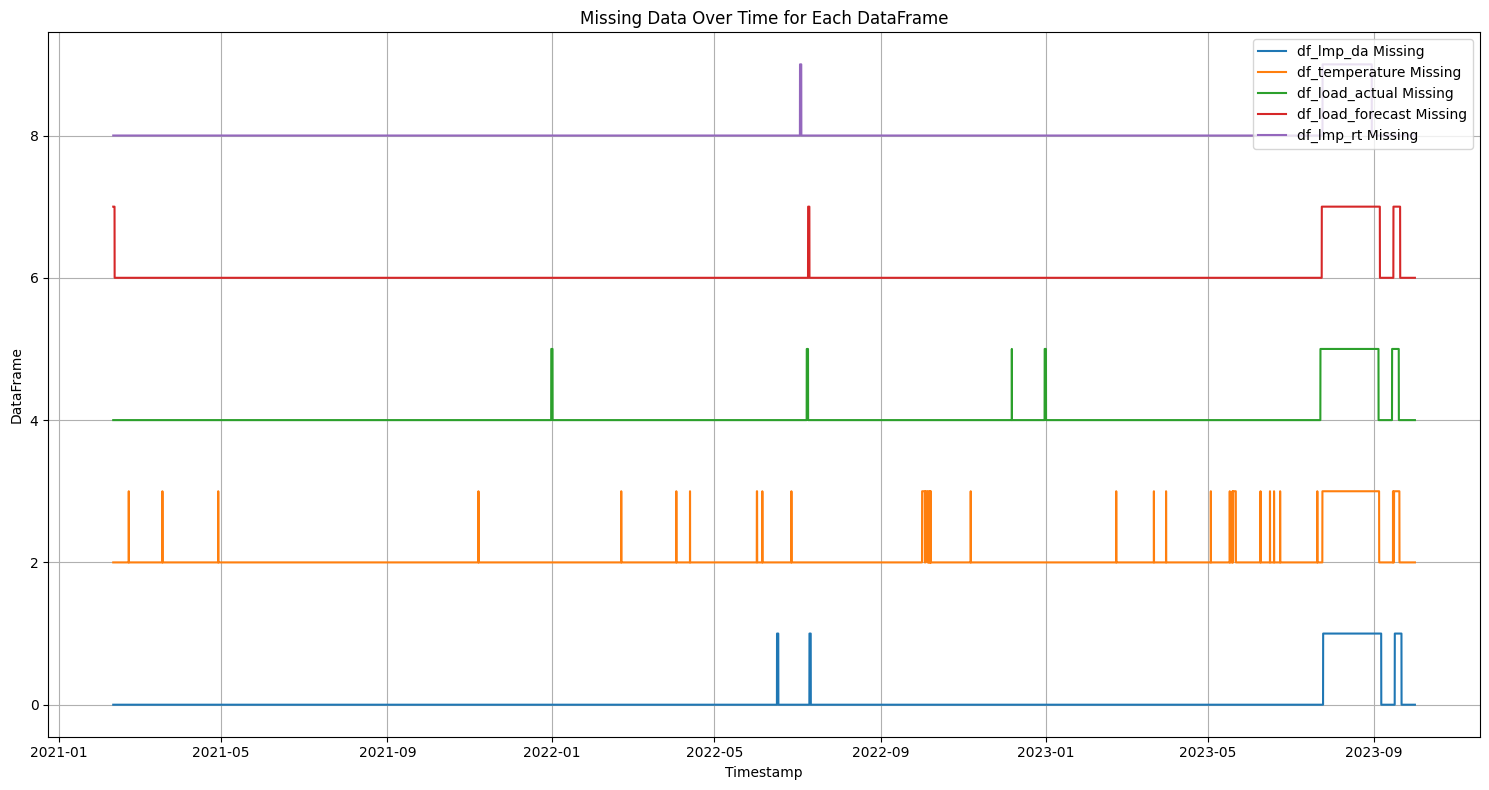

In [ ]:
# Create a complete hourly time series between min_timestamp and max_timestamp
full_time_series = pd.Series(pd.date_range(start=min_timestamp, end=max_timestamp, freq='H'))

# Prepare a DataFrame for plotting missing data indicators
df_missing_data_plot = pd.DataFrame({'Timestamp': full_time_series})

dataframes_to_check = {
    'df_lmp_da': df_lmp_da,
    'df_temperature': df_temperature,
    'df_load_actual': df_load_actual,
    'df_load_forecast': df_load_forecast,
    'df_lmp_rt': df_lmp_rt
}

# Populate the df_missing_data_plot with missing indicators (1 if missing, 0 if present)
for name, df_obj in dataframes_to_check.items():
    # Left merge with the full time series to find all missing points or NaNs in data columns
    merged_with_full_series = pd.merge(full_time_series.to_frame(name='Timestamp'),
                                       df_obj,
                                       on='Timestamp',
                                       how='left')

    # Identify data columns (excluding Timestamp itself)
    data_columns_of_df_obj = [col for col in df_obj.columns if col != 'Timestamp']

    # Mark as missing if any data column is NaN for that timestamp
    # If data_columns_of_df_obj is empty (e.g. only Timestamp), this would cause an error.
    # However, all our dfs have data columns. So, this should be fine.
    df_missing_data_plot[name + '_missing'] = merged_with_full_series[data_columns_of_df_obj].isnull().any(axis=1).astype(int)

# Plotting the missing data
plt.figure(figsize=(15, 8))

# Plot the missing indicators for each DataFrame
# The value 'i * 2' creates a base offset for each DataFrame line
# The '+ df_missing_data_plot[name + '_missing']' then adds 0 (present) or 1 (missing) to this base
for i, (name, _) in enumerate(dataframes_to_check.items()):
    plt.plot(df_missing_data_plot['Timestamp'], df_missing_data_plot[name + '_missing'] + i * 2, label=f'{name} Missing')

plt.xlabel('Timestamp')
plt.ylabel('DataFrame')
plt.title('Missing Data Over Time for Each DataFrame')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
min_timestamp = pd.to_datetime('2021-02-11 06:00:00')
max_timestamp = pd.to_datetime('2023-07-23 00:00:00')

df_lmp_da = df_lmp_da[(df_lmp_da['Timestamp'] >= min_timestamp) & (df_lmp_da['Timestamp'] <= max_timestamp)]
df_lmp_da.reset_index(drop=True, inplace=True)


Next, we will fill missing datetimes. Since we are forecasting the real time prices for Illinois hub, we should not use future data to fill the past to avoid leakage. We will use only past-aware fills.

In [ ]:
def fill_df(df, min_timestamp, max_timestamp):
  # Create a complete hourly time series between min_timestamp and max_timestamp
  full_time_series = pd.Series(pd.date_range(start=min_timestamp, end=max_timestamp, freq='H'))
  # Check if 'index' column exists and rename it to 'Timestamp' if it does, before setting the index
  if 'index' in df.columns and 'Timestamp' not in df.columns:
    df.rename(columns={'index': 'Timestamp'}, inplace=True)

  # Ensure 'Timestamp' column is unique before setting it as index
  df.drop_duplicates(subset=['Timestamp'], keep='first', inplace=True)

  # Remove limit from ffill to fill all consecutive missing values
  df = df.set_index('Timestamp').reindex(full_time_series).ffill().reset_index()
  # After reset_index, the Timestamp column might be named 'index' again, so ensure it's named 'Timestamp'.
  df.rename(columns={'index': 'Timestamp'}, inplace=True)
  return df

df_lmp_da = fill_df(df_lmp_da, min_timestamp, max_timestamp)
df_temperature = fill_df(df_temperature, min_timestamp, max_timestamp)
df_load_actual = fill_df(df_load_actual, min_timestamp, max_timestamp)
df_lmp_rt = fill_df(df_lmp_rt, min_timestamp, max_timestamp)
df_load_forecast = fill_df(df_load_forecast, min_timestamp, max_timestamp)

/tmp/ipython-input-1080358076.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_series = pd.Series(pd.date_range(start=min_timestamp, end=max_timestamp, freq='H'))
/tmp/ipython-input-1080358076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['Timestamp'], keep='first', inplace=True)
/tmp/ipython-input-1080358076.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_series = pd.Series(pd.date_range(start=min_timestamp, end=max_timestamp, freq='H'))
/tmp/ipython-input-1080358076.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_series = pd.Series(pd.date_range(start=min_timestamp, en

In [ ]:
display(df_lmp_da.describe())
display(df_lmp_da.info())

,Timestamp,Arkansas DALMP,Illinois DALMP,Indiana DALMP,Michigan DALMP,Minnesota DALMP
count,21403,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000
mean,2022-05-03 03:00:00,44.238055,46.805554,51.746380,48.816852,38.665193
min,2021-02-11 06:00:00,10.270000,-0.900000,11.820000,11.480000,-6.490000
25%,2021-09-22 04:30:00,26.390000,26.810000,30.340000,28.850000,23.155000
50%,2022-05-03 03:00:00,37.440000,39.260000,44.670000,42.100000,32.850000
75%,2022-12-12 01:30:00,53.235000,57.890000,63.565000,60.050000,48.105000
max,2023-07-23 00:00:00,689.590000,498.890000,547.480000,443.720000,606.820000
std,NaN,30.154877,29.961937,31.534699,28.430541,27.400717


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21403 entries, 0 to 21402
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Timestamp        21403 non-null  datetime64[ns]
 1   Arkansas DALMP   21403 non-null  float64       
 2   Illinois DALMP   21403 non-null  float64       
 3   Indiana DALMP    21403 non-null  float64       
 4   Michigan DALMP   21403 non-null  float64       
 5   Minnesota DALMP  21403 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1003.4 KB


None

In [ ]:
display(df_lmp_rt.describe())
display(df_lmp_rt.info())

,Timestamp,Arkansas RTLMP,Illinois RTLMP,Indiana RTLMP,Michigan RTLMP,Minnesota RTLMP
count,21403,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000
mean,2022-05-03 03:00:00,44.134190,45.745547,51.304717,47.731294,37.991256
min,2021-02-11 06:00:00,-8.560000,-74.950000,-4.430000,-14.950000,-62.280000
25%,2021-09-22 04:30:00,24.640000,24.220000,27.110000,26.175000,20.820000
50%,2022-05-03 03:00:00,34.800000,35.190000,40.080000,37.710000,29.450000
75%,2022-12-12 01:30:00,50.840000,54.800000,60.950000,56.370000,45.985000
max,2023-07-23 00:00:00,3480.750000,2178.340000,2411.710000,2280.330000,1781.780000
std,NaN,59.287688,46.042142,52.288514,45.243000,41.263644


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21403 entries, 0 to 21402
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Timestamp        21403 non-null  datetime64[ns]
 1   Arkansas RTLMP   21403 non-null  float64       
 2   Illinois RTLMP   21403 non-null  float64       
 3   Indiana RTLMP    21403 non-null  float64       
 4   Michigan RTLMP   21403 non-null  float64       
 5   Minnesota RTLMP  21403 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1003.4 KB


None

In [ ]:
display(df_load_actual.describe())
display(df_load_actual.info())

,Timestamp,Total Actual Load,LRZ 1_actual,LRZ 2_ 7_actual,LRZ 3_ 5_actual,LRZ 4_actual,LRZ 6_actual,LRZ 8_ 9_ 10_actual
count,21403,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000
mean,2022-05-03 03:00:00,75516.513159,11072.993572,18305.493371,10279.981389,5302.159037,10415.286910,20140.598881
min,2021-02-11 06:00:00,52125.790000,7601.940000,12103.280000,6603.030000,3515.060000,6776.730000,12758.880000
25%,2021-09-22 04:30:00,67225.790000,9920.050000,16000.140000,9007.125000,4627.920000,9196.370000,17411.475000
50%,2022-05-03 03:00:00,73635.410000,10918.930000,18004.690000,9970.360000,5111.920000,10135.960000,19208.380000
75%,2022-12-12 01:30:00,81475.075000,12093.525000,19807.515000,11265.510000,5805.500000,11403.260000,22160.075000
max,2023-07-23 00:00:00,120683.750000,17404.620000,33064.270000,16933.510000,9083.020000,17505.370000,32719.640000
std,NaN,11826.927231,1601.586482,3129.872681,1769.108244,940.545403,1708.705197,3798.245293


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21403 entries, 0 to 21402
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            21403 non-null  datetime64[ns]
 1   Total Actual Load    21403 non-null  float64       
 2   LRZ 1_actual         21403 non-null  float64       
 3   LRZ 2_ 7_actual      21403 non-null  float64       
 4   LRZ 3_ 5_actual      21403 non-null  float64       
 5   LRZ 4_actual         21403 non-null  float64       
 6   LRZ 6_actual         21403 non-null  float64       
 7   LRZ 8_ 9_ 10_actual  21403 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.3 MB


None

In [ ]:
display(df_load_forecast.describe())
display(df_load_forecast.info())

,Timestamp,Total Forecast Load,LRZ 1_forecast,LRZ 2_ 7_forecast,LRZ 3_ 5_forecast,LRZ 4_forecast,LRZ 6_forecast,LRZ 8_ 9_ 10_forecast
count,21403,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000,21403.000000
mean,2022-05-03 03:00:00,75415.946456,11023.298883,18435.938093,10233.666028,5287.188572,10400.690277,20035.164603
min,2021-02-11 06:00:00,43250.000000,1923.000000,8320.000000,4340.000000,328.000000,6381.000000,13149.000000
25%,2021-09-22 04:30:00,67235.500000,9879.000000,16281.500000,8972.000000,4626.000000,9196.000000,17403.500000
50%,2022-05-03 03:00:00,73506.000000,10871.000000,18076.000000,9935.000000,5102.000000,10113.000000,19134.000000
75%,2022-12-12 01:30:00,81196.500000,12046.500000,19852.500000,11179.000000,5778.000000,11353.000000,21999.500000
max,2023-07-23 00:00:00,122884.000000,18078.000000,33318.000000,17406.000000,9131.000000,17771.000000,33152.000000
std,NaN,11848.023272,1628.976555,3092.665237,1788.767015,961.364475,1699.880478,3753.393531


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21403 entries, 0 to 21402
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              21403 non-null  datetime64[ns]
 1   Total Forecast Load    21403 non-null  float64       
 2   LRZ 1_forecast         21403 non-null  float64       
 3   LRZ 2_ 7_forecast      21403 non-null  float64       
 4   LRZ 3_ 5_forecast      21403 non-null  float64       
 5   LRZ 4_forecast         21403 non-null  float64       
 6   LRZ 6_forecast         21403 non-null  float64       
 7   LRZ 8_ 9_ 10_forecast  21403 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.3 MB


None

In [ ]:
display(df_temperature.describe())
display(df_temperature.info())

,Timestamp,Argonne_temp,Indianapolis_temp,Minneapolis_temp
count,21403,21403.000000,21403.000000,21403.000000
mean,2022-05-03 03:00:00,51.995644,55.460585,48.861188
min,2021-02-11 06:00:00,-11.200000,-9.000000,-18.900000
25%,2021-09-22 04:30:00,36.485000,41.000000,30.900000
50%,2022-05-03 03:00:00,52.880000,57.000000,50.000000
75%,2022-12-12 01:30:00,69.080000,71.100000,70.000000
max,2023-07-23 00:00:00,95.540000,99.000000,100.900000
std,NaN,20.084421,19.008982,24.214841


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21403 entries, 0 to 21402
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          21403 non-null  datetime64[ns]
 1   Argonne_temp       21403 non-null  float64       
 2   Indianapolis_temp  21403 non-null  float64       
 3   Minneapolis_temp   21403 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 669.0 KB


None

# Cyclical Data
Our features include Day of Week, Hour of Day, Month. We should not one-hot encode date information as these are cyclical data. Use a sine an cosine transformations.


In [ ]:
df_cyclical_features = df_lmp_rt[['Timestamp']].copy()

# Day of week: (Monday=0, Sunday=6), max_value = 7
d0 = df_cyclical_features['Timestamp'].dt.dayofweek
df_cyclical_features['week_sin'] = np.sin(2 * np.pi * d0 / 7)
df_cyclical_features['week_cos'] = np.cos(2 * np.pi * d0 / 7)

# Hour of day: 0-23, max_value = 24
h0 = df_cyclical_features['Timestamp'].dt.hour
df_cyclical_features['hour_sin'] = np.sin(2 * np.pi * h0 / 24)
df_cyclical_features['hour_cos'] = np.cos(2 * np.pi * h0 / 24)

# Month: 0-11, max_value = 12
m0 = df_cyclical_features['Timestamp'].dt.month - 1
df_cyclical_features['month_sin'] = np.sin(2 * np.pi * m0/ 12)
df_cyclical_features['month_cos'] = np.cos(2 * np.pi * m0 / 12)

df_cyclical_features.head()

,Timestamp,week_sin,week_cos,hour_sin,hour_cos,month_sin,month_cos
0,2021-02-11 06:00:00,0.433884,-0.900969,1.000000,6.123234e-17,0.5,0.866025
1,2021-02-11 07:00:00,0.433884,-0.900969,0.965926,-2.588190e-01,0.5,0.866025
2,2021-02-11 08:00:00,0.433884,-0.900969,0.866025,-5.000000e-01,0.5,0.866025
3,2021-02-11 09:00:00,0.433884,-0.900969,0.707107,-7.071068e-01,0.5,0.866025
4,2021-02-11 10:00:00,0.433884,-0.900969,0.500000,-8.660254e-01,0.5,0.866025


# Pickle the Data
Now, we will combine everything into a single data frame, this is more convenient for feature exploration.  Our target label is `Illinois_LMP_RT[t+1]`.
We will include some lagged (or maybe rolling) features, but we leave this step after data exploration. We also leave normalization for this step.  Our data is not too large to require pickling before doing these steps.

In [ ]:
# Target
df_illinois_rt_lmp_target = df_lmp_rt[['Timestamp', 'Illinois RTLMP']].copy()
df_illinois_rt_lmp_target .rename(columns={'Illinois RTLMP': 'Illinois RTLMP Target'}, inplace=True)
# Shift target variable t+1. The last value will be NaN.
df_illinois_rt_lmp_target['Illinois RTLMP Target'] = df_illinois_rt_lmp_target['Illinois RTLMP Target'].shift(-1)

df_illinois_rt_lmp_target.tail()

,Timestamp,Illinois RTLMP Target
21398,2023-07-22 20:00:00,37.74
21399,2023-07-22 21:00:00,57.83
21400,2023-07-22 22:00:00,35.84
21401,2023-07-22 23:00:00,38.23
21402,2023-07-23 00:00:00,NaN


In [ ]:
# Combine all dataframes into a single one
df_combined = df_illinois_rt_lmp_target.merge(df_lmp_rt, on='Timestamp', how='inner')
df_combined = df_combined.merge(df_lmp_da, on='Timestamp', how='inner')
df_combined = df_combined.merge(df_load_actual, on='Timestamp', how='inner')
df_combined = df_combined.merge(df_load_forecast, on='Timestamp', how='inner')
df_combined = df_combined.merge(df_temperature, on='Timestamp', how='inner')
df_combined = df_combined.merge(df_cyclical_features, on='Timestamp', how='inner')

# Drop rows where the target variable is NaN (the very last row)
df_combined.dropna(subset=['Illinois RTLMP Target'], inplace=True)

df_combined.head()

,Timestamp,Illinois RTLMP Target,Arkansas RTLMP,Illinois RTLMP,Indiana RTLMP,Michigan RTLMP,Minnesota RTLMP,Arkansas DALMP,Illinois DALMP,Indiana DALMP,...,LRZ 8_ 9_ 10_forecast,Argonne_temp,Indianapolis_temp,Minneapolis_temp,week_sin,week_cos,hour_sin,hour_cos,month_sin,month_cos
0,2021-02-11 06:00:00,23.47,25.30,24.61,25.33,25.21,26.94,23.83,32.01,32.33,...,17715.0,14.18,19.0,-6.0,0.433884,-0.900969,1.000000,6.123234e-17,0.5,0.866025
1,2021-02-11 07:00:00,23.27,24.44,23.47,24.24,24.10,25.61,23.53,29.81,30.21,...,17222.0,9.32,19.0,-8.0,0.433884,-0.900969,0.965926,-2.588190e-01,0.5,0.866025
2,2021-02-11 08:00:00,25.15,24.23,23.27,24.03,23.88,25.34,23.12,28.80,29.40,...,16942.0,7.88,18.0,-8.0,0.433884,-0.900969,0.866025,-5.000000e-01,0.5,0.866025
3,2021-02-11 09:00:00,24.71,25.53,25.15,26.01,25.84,27.37,22.99,29.13,29.70,...,16826.0,5.72,18.0,-8.0,0.433884,-0.900969,0.707107,-7.071068e-01,0.5,0.866025
4,2021-02-11 10:00:00,22.82,24.64,24.71,25.58,25.42,27.15,23.64,29.31,29.73,...,16893.0,5.00,18.0,-9.0,0.433884,-0.900969,0.500000,-8.660254e-01,0.5,0.866025


In [ ]:
# Print column names
print(*df_combined.columns, sep="\n")

Timestamp
Illinois RTLMP Target
Arkansas RTLMP
Illinois RTLMP
Indiana RTLMP
Michigan RTLMP
Minnesota RTLMP
Arkansas DALMP
Illinois DALMP
Indiana DALMP
Michigan DALMP
Minnesota DALMP
Total Actual Load
LRZ 1_actual
LRZ 2_ 7_actual
LRZ 3_ 5_actual
LRZ 4_actual
LRZ 6_actual
LRZ 8_ 9_ 10_actual
Total Forecast Load
LRZ 1_forecast
LRZ 2_ 7_forecast
LRZ 3_ 5_forecast
LRZ 4_forecast
LRZ 6_forecast
LRZ 8_ 9_ 10_forecast
Argonne_temp
Indianapolis_temp
Minneapolis_temp
week_sin
week_cos
hour_sin
hour_cos
month_sin
month_cos


Right now, out combined data has 35 columns including real time prices of the Hubs. Obviously, we will either shift these data or remove altogether.


## Debugging and working datasets

In [ ]:
datadir = '/content/drive/MyDrive/miso_project'
data_pickled_dir = os.path.join(datadir, 'data_pickled')
os.makedirs(data_pickled_dir, exist_ok=True)

#  Prepare 2 months worth of data for debugging
start_date = df_combined['Timestamp'].min()
end_date_debug = start_date + timedelta(days=60) # Approximately 2 months
df_debug = df_combined[df_combined['Timestamp'] <= end_date_debug].copy()

# Save debugging data
debug_file_path = os.path.join(data_pickled_dir, 'df_combined_debug.pkl')
with open(debug_file_path, 'wb') as f:
    pickle.dump(df_debug, f)
print(f"Debugging data (2 months) saved to: {debug_file_path}")

Debugging data (2 months) saved to: /content/drive/MyDrive/miso_project/data_pickled/df_combined_debug.pkl


In [ ]:
# Pickle working data (all)
working_file_path = os.path.join(data_pickled_dir , 'df_combined_working.pkl')
with open(working_file_path, 'wb') as f:
    pickle.dump(df_combined, f)
print(f"Working data (all data) saved to: {working_file_path}")

Working data (all data) saved to: /content/drive/MyDrive/miso_project/data_pickled/df_combined_working.pkl


In [ ]:
# Display basic info for confirmation
print(f"\nShape of debugging DataFrame: {df_debug.shape}")
print(f"Shape of working DataFrame: {df_combined.shape}")


Shape of debugging DataFrame: (1441, 35)
Shape of working DataFrame: (21402, 35)
